Below is the N-body simulation as well as multiple different simulations we ran. The first cell is the whole of the simulation function n_body_model() and subsequent cells run the function on different initial conditions with different settings. 

Note: to run a given simulation, you must run the cell that defines the simulation function first and then run all of the cells for a given simulation in order. To run the solar system simulation with Pluto, you also need to run the cell titled "Determining Initial Conditions for the Solar System" prior to running any of the cells under the Pluto section.

In [1]:
# import packages

import numpy as np
import math
from scipy.optimize import bisect
import matplotlib.pyplot as plt

# initial conditions format is [parameter planet 1, parameter planet 2, ...] where parameter planet = [position in x (s_x), s_y, s_z, v_x, v_y, v_z, mass, radius]
# input in arrays, output in arrays
# other inputs are dt (size of the time step), t_0 (initial time), t_f (final time) 
# optional parameters are the value of the gravitational constant G and do_collisions, which is automatically set to false
# when do_collisions is set to true, the simulation will do inelastic collisions when two planets are overlapping
# the function uses leapfrog integration to determine the positions and velocities of the bodies after each timestep
# the function starts at the initial conditions and t_0 and integrates up to when t_f is passed
# the function also computes the energy of the system based on the initial conditions and after every time step
# the outputs are arrays of the times, positions, velocities, kinetic energies, potential energies, and total energies
# output arrays are organized such that the indices are ordered loop number, planet number, direction (x, y, or z)
# all of the energy arrays are 2D and lack a direction index; times is 1D and only has the loop number index
# the final output is an array called collisions that details any collisions that may have occurred
# the format for the array is [i, j, loop_num] for each collision
# i is the index of the first planet involved in the collision, j is the index of the second, 
# and loop_num refers to the index of the time in the time array prior to the collision


def n_body_model(initial_conditions, dt, t_0, t_f, do_collisions = False, G = 6.67430*10**(-11)):
    
    # here we determine the number of planets to make for loops easier

    num_planets = len(initial_conditions)
  
    # extract info from inputs and define sizes of output matrices from input parameters

    masses = initial_conditions[0:num_planets, 6]  
    radii = initial_conditions[0:num_planets, 7]

    positions = initial_conditions[0:num_planets, 0:3]
    positions = positions.flatten()
    positions.resize((math.ceil((t_f-t_0)/dt) + 2) * num_planets * 3)
    positions = positions.reshape((math.ceil((t_f-t_0)/dt) + 2, num_planets, 3))

    velocities = initial_conditions[0:num_planets, 3:6]
    velocities = velocities.flatten()
    velocities.resize((math.ceil((t_f-t_0)/dt) + 2) * num_planets * 3)
    velocities = velocities.reshape((math.ceil((t_f-t_0)/dt) + 2, num_planets, 3))

    times = np.empty((math.ceil((t_f-t_0)/dt) + 2))
    energies = np.empty((math.ceil((t_f-t_0)/dt) + 2))
    kinetic = np.empty((math.ceil((t_f-t_0)/dt) + 2))
    potential = np.empty((math.ceil((t_f-t_0)/dt) + 2))

    # define variable to keep track of the number of collisions and variable to keep track of essential collision info

    collision_num = 0
    collisions = None

    # set loop number to be 0

    loop_num = 0

    # define an array in order to retain acceleration data and intermediate velocity data between different for loops

    accels = np.empty((num_planets, 3))
    int_velocities = np.empty((num_planets, 3))
    
    # here we internally define a function to find the energies for a given loop number

    def find_energy(it_num):
        
        # we define the potential and kinetic energy and set them to be zero
        
        potential = 0
        kinetic = 0
        
        # we then iterate over the planets 
        
        for i in range(num_planets):
            
            # we add the kinetic energy from each planet
            
            kinetic += 1/2 * masses[i] * np.sqrt(velocities[it_num+1][i][0]**2 + velocities[it_num+1][i][1]**2 + velocities[it_num+1][i][2]**2)
            
            # we then find the potential energy between the ith planet and all other planets with a larger index number
            
            s_x, s_y, s_z = positions[it_num+1][i][0], positions[it_num+1][i][1], positions[it_num+1][i][2]
            for j in range(num_planets):
                if j > i and masses[j] != 0:
                    r_vector = -1 * np.array([(s_x-positions[it_num+1][j][0]), (s_y-positions[it_num+1][j][1]), (s_z-positions[it_num+1][j][2])])
                    r = np.sqrt(np.sum(r_vector**2))
                    potential += -masses[i] * masses[j] * G / r
                    
        #we return the total energy in addition to the kinetic and potential energies separately
                    
        return kinetic + potential, kinetic, potential
    
    # we then record the intial energies

    energies[0] = find_energy(loop_num - 1)[0]
    kinetic[0] = find_energy(loop_num - 1)[1]
    potential[0] = find_energy(loop_num - 1)[2]

    # loop and do cool shit until we pass t final
    # cool shit includes computing positions, velocities, checking for collisions, and computing energies in addition
    # to updating the loop number and the time array for each time step
  
    while times[loop_num] < t_f + dt:

        # here we perform the first two steps of leapfrog integration.
        # first we compute our intermediate velocity and then we compute our new positions at the end of the time step

        for i in range(num_planets):

            # Note: all masses != 0 are checking against planets that have been "absorbed" by collisions in order to avoid calculating new info for them

            if masses[i] != 0:

                # pull accelerations from the last loop since we apply the same acceleration at the end of the ith loop as 
                # the beginning of the (i+1)th loop
        
                a_x = accels[i][0]
                a_y = accels[i][1]
                a_z = accels[i][2]

                # extract latest position components

                s_x, s_y, s_z = positions[loop_num][i][0], positions[loop_num][i][1], positions[loop_num][i][2]

                # if we have no prior acceleration data to pull from we compute it here

                if loop_num == 0:
                        a_x, a_y, a_z = 0, 0, 0
                        
                        # for each planet we add its contribution to the acceleration of the planet we are modeling
                        
                        for j in range(num_planets):
                            if (j != i) and (masses[j] != 0):

                                # find the radius vector, radius magnetude, and radius unit vector

                                r_vector = -1 * np.array([(s_x-positions[loop_num][j][0]), (s_y-positions[loop_num][j][1]), (s_z-positions[loop_num][j][2])])
                                r = np.sqrt(np.sum(r_vector**2))
                                r_hat = r_vector / r

                                # compute the magnitude of the acceleration on the body and its components

                                a_j = masses[j] * G / (r**2)
                                ax_j, ay_j, az_j = r_hat * a_j

                                # add contribution from jth body to acceleration components

                                a_x += ax_j
                                a_y += ay_j
                                a_z += az_j

                # extract latest velocity componets

                v_x, v_y, v_z = velocities[loop_num][i][0], velocities[loop_num][i][1], velocities[loop_num][i][2]
                
                # find intermediate velocity

                v_x += a_x * dt / 2.0
                v_y += a_y * dt / 2.0
                v_z += a_z * dt / 2.0

                # calculate new positions

                new_s_x = v_x * dt + s_x
                new_s_y = v_y * dt + s_y
                new_s_z = v_z * dt + s_z
                
                # record positions and store intermediate velocities for later
        
                positions[loop_num + 1][i][0] = new_s_x
                positions[loop_num + 1][i][1] = new_s_y
                positions[loop_num + 1][i][2] = new_s_z
        
                int_velocities[i][0] = v_x
                int_velocities[i][1] = v_y
                int_velocities[i][2] = v_z
                
            # in the event that a planet's mass is 0 we give it no coordinates
        
            else:
                positions[loop_num + 1][j][0] = None
                positions[loop_num + 1][j][1] = None
                positions[loop_num + 1][j][2] = None
                
        # this is the collision detection system that only activates when do_collisions is set to true
                
        if do_collisions == True:  
            
            # for each planet we check to see if it has collided with every other planet, excluding planets where mass = 0 (i.e. they do not exist)
            
            for i in range(num_planets):
                for j in range(num_planets):
                    if (j > i) and (masses[i] != 0) and (masses[j] != 0):
                        
                        # we use two tests for collisions since they should deal with all cases of planet collisions
                        # if a collision between two planets occurred over the course of a time step, one of two things is true
                        # one, at the end of the timestep, the distance between two planets is less than the sum of their radii
                        # two, at some time during the timestep (not at an endpoint), the distance between the two planets is 
                        # less than the sum of their radii. If we define a function that gives the distance between the surfaces
                        # of two planets, its derivative will go from negative to positive over the course of a time step.
                        # we can use the intermediate value theorem to find the zero of this derivative and check to see if a collision
                        # occurred by the first criteria.
                        # the only scenario this system cannot account for is if the initial conditions are of coinciding bodies
                        # the collision detection system will then fail.
                        
                        # this function defines the derivative of the distance between the surfaces of two planets as a function of time

                        def distance_derivative(t):
                            r_x = (positions[loop_num][i][0] + int_velocities[i][0] * t - positions[loop_num][j][0] - int_velocities[j][0] * t)
                            r_y = (positions[loop_num][i][1] + int_velocities[i][1] * t - positions[loop_num][j][1] - int_velocities[j][1] * t)
                            r_z = (positions[loop_num][i][2] + int_velocities[i][2] * t - positions[loop_num][j][2] - int_velocities[j][2] * t)
                            distance = np.sqrt(r_x**2 + r_y**2 + r_z**2)
                            numerator = r_x * (int_velocities[i][0] - int_velocities[j][0]) + r_y * (int_velocities[i][1] - int_velocities[j][1]) + r_z * (int_velocities[i][2] - int_velocities[j][2])
                            return numerator / distance
                        
                        # this function defines the distance between the surfaces of two planets as a function of time

                        def surface_distance(t):
                            r_x = (positions[loop_num][i][0] + int_velocities[i][0] * t - positions[loop_num][j][0] - int_velocities[j][0] * t)
                            r_y = (positions[loop_num][i][1] + int_velocities[i][1] * t - positions[loop_num][j][1] - int_velocities[j][1] * t)
                            r_z = (positions[loop_num][i][2] + int_velocities[i][2] * t - positions[loop_num][j][2] - int_velocities[j][2] * t)
                            distance = np.sqrt(r_x**2 + r_y**2 + r_z**2)
                            return distance - radii[i] - radii[j]     
                        
                        # both of the above functions use the intermediate velocities of the planets and their positions prior to the timestep
                        # to compute the surface distance and its derivative as a function of time over the course of a time step
                        
                        # we first check to seeif either of our conditions are met for a collision

                        if (surface_distance(dt) < 0) or (distance_derivative(0) < 0 and distance_derivative(dt) >= 0):
                            
                            # we define some variables. collision_time will be the time the collision occurred. We defined it as zero 
                            # because it notably cannot be zero because we look to find collisions after motion has begun for a time step
                            # root_time is the time when the distance derivative is zero. Same deal here. The derivative cannot be zero due 
                            # to our criteria. derivative_marker we use to denote if the second condition has been met
                        
                            collision_time = 0
                            root_time = 0
                            derivative_marker = False
                            
                            # if the first condition is met we use the bisect function to find the collision time since when the surface distance
                            # is first zero, that is the time of collision

                            if (surface_distance(dt) < 0): 
                                collision_time = bisect(surface_distance, 0, dt, xtol = 1e-8)
                                
                            # if the distance derivative is zero at the end of the time step, that is our root_time. We also mark the derivative_marker
                                                    
                            elif(distance_derivative(dt) == 0):
                                derivative_marker = True
                                root_time = dt
                                
                            # if the derivative instead changed directions, we bisect to find the root_time
                            # we also mark the derivative_marker
                                
                            elif(distance_derivative(dt) > 0):
                                derivative_marker = True
                                root_time = bisect(distance_derivative, 0, dt, xtol = 1e-8)
                                
                            # if the derivative_marker is true, we check to see if the surface distance is negative at the root_time
                            # if so then we bisect again to find the collision time

                            if derivative_marker == True:
                                if surface_distance(root_time) < 0:
                                    collision_time = bisect(surface_distance, 0, root_time, xtol = 1e-8)
                                    
                            # if we have a collision, we then perform a procedure to perform an inelastic collision

                            if collision_time != 0:
                                
                                # since the collision is inelastic, mass is conserved

                                new_mass = masses[i] + masses[j]
                                
                                # we change our variable name for clarity. t_prior is the amount of time in a timestep prior to a collision

                                t_prior = collision_time
                                
                                # we take out the intermediate velocities for the two colliding bodies

                                v_x_prior_i = int_velocities[i][0]
                                v_y_prior_i = int_velocities[i][1]
                                v_z_prior_i = int_velocities[i][2]

                                v_x_prior_j = int_velocities[j][0]
                                v_y_prior_j = int_velocities[j][1]
                                v_z_prior_j = int_velocities[j][2]
                                
                                # we then compute the positions of the bodies immediately before the collision

                                s_x_prior_i = int_velocities[i][0] * t_prior + positions[loop_num][i][0]
                                s_y_prior_i = int_velocities[i][1] * t_prior + positions[loop_num][i][1]
                                s_z_prior_i = int_velocities[i][2] * t_prior + positions[loop_num][i][2]

                                s_x_prior_j = int_velocities[j][0] * t_prior + positions[loop_num][j][0]
                                s_y_prior_j = int_velocities[j][1] * t_prior + positions[loop_num][j][1]
                                s_z_prior_j = int_velocities[j][2] * t_prior + positions[loop_num][j][2]
                                
                                # we put the new planet at the center of mass of the two planets immediately prior to the collision

                                col_s_x = (s_x_prior_i * masses[i] + s_x_prior_j * masses[j]) / new_mass
                                col_s_y = (s_y_prior_i * masses[i] + s_y_prior_j * masses[j]) / new_mass
                                col_s_z = (s_z_prior_i * masses[i] + s_z_prior_j * masses[j]) / new_mass
                                
                                # we define the new velocity of the combined planet using conservation of momentum in an inelastic collision

                                col_v_x = (v_x_prior_i * masses[i] + v_x_prior_j * masses[j]) / new_mass
                                col_v_y = (v_y_prior_i * masses[i] + v_y_prior_j * masses[j]) / new_mass
                                col_v_z = (v_z_prior_i * masses[i] + v_z_prior_j * masses[j]) / new_mass
                                
                                # the amount of time we have left

                                t_left = dt - collision_time
                                
                                # we let the planet keep drifting until the end of the time step

                                new_s_x = col_v_x * t_left + col_s_x
                                new_s_y = col_v_y * t_left + col_s_y
                                new_s_z = col_v_z * t_left + col_s_z
                                
                                # we record the position information using the convention that the new planet assumes the 
                                # lower index of the two planets involved in the collision

                                positions[loop_num + 1][i][0] = new_s_x
                                positions[loop_num + 1][i][1] = new_s_y
                                positions[loop_num + 1][i][2] = new_s_z
                                
                                # we record new intermediate velocities

                                int_velocities[i][0] = col_v_x
                                int_velocities[i][1] = col_v_y
                                int_velocities[i][2] = col_v_z
                                
                                # the higher of the two indexes gets Nones from here on out for position and velocity data

                                positions[loop_num + 1][j][0] = None
                                positions[loop_num + 1][j][1] = None
                                positions[loop_num + 1][j][2] = None

                                int_velocities[j][0] = None
                                int_velocities[j][1] = None
                                int_velocities[j][2] = None
                                
                                # the higher indexed planet no longer exists and has no acceleration

                                accels[j][0], accels[j][1], accels[j][2] = 0, 0, 0
                                
                                # we record new masses. we define the mass of the jth planet to be zero so the program 
                                # can exclude considerations of it throughout the rest of the simulation

                                masses[i] = new_mass
                                masses[j] = 0
                                
                                # assuming constant volume (likely) we find a new radius

                                radii[i] = (radii[i]**3 + radii[j]**3)**(1/3)
                                radii[j] = None
                                
                                # we then update the collision output with an if else in the event this is the first collision

                                if collision_num == 0:
                                    collisions = np.empty((1, 3))
                                else:
                                    collisions.resize((collision_num+1, 3))

                                collisions[collision_num][0] = i
                                collisions[collision_num][1] = j
                                collisions[collision_num][2] = loop_num
                                
                                # update the number of collisions
                                
                                collision_num += 1
                                
                
        # this for loop completes the final step of leapfrog integration
        
        for i in range(num_planets):
            if masses[i] != 0:
                
                # we reset the accelerations
        
                a_x = 0
                a_y = 0
                a_z = 0
                
                # pull out the positions from the end of the time step

                s_x, s_y, s_z = positions[loop_num+1][i][0], positions[loop_num+1][i][1], positions[loop_num+1][i][2]
                
                # we now iterate over all of the other planets and add their contribution to the gravitational acceleration

                for j in range(num_planets):
                    if (j != i) and (masses[j] != 0):

                        # find the radius vector, radius magnetude, and radius unit vector

                        r_vector = -1 * np.array([(s_x-positions[loop_num+1][j][0]), (s_y-positions[loop_num+1][j][1]), (s_z-positions[loop_num+1][j][2])])
                        r = np.sqrt(np.sum(r_vector**2))
                        r_hat = r_vector / r

                        # compute the magnitude of the acceleration on the body and its components

                        a_j = masses[j] * G / (r**2)
                        ax_j, ay_j, az_j = r_hat * a_j

                        # add contribution from jth body to acceleration components

                        a_x += ax_j
                        a_y += ay_j
                        a_z += az_j
                        
                # we pull back out the intermediate velocities

                v_x, v_y, v_z = int_velocities[i][0], int_velocities[i][1], int_velocities[i][2]
                
                # we compute the velocities at the end of the time step and record them

                new_v_x = v_x + a_x * dt/2
                new_v_y = v_y + a_y * dt/2
                new_v_z = v_z + a_z * dt/2

                velocities[loop_num + 1][i][0] = new_v_x
                velocities[loop_num + 1][i][1] = new_v_y
                velocities[loop_num + 1][i][2] = new_v_z

                # store acceleration components for the next loop

                accels[i][0], accels[i][1], accels[i][2] = a_x, a_y, a_z

            # if the body no longer exists, fill its vcomponents with None

            else:

                velocities[loop_num + 1][j][0] = None
                velocities[loop_num + 1][j][1] = None
                velocities[loop_num + 1][j][2] = None
                
        # update energy arrays by running the energy function
        
        energy = find_energy(loop_num)
        energies[loop_num + 1] = energy[0]
        kinetic[loop_num + 1] = energy[1]
        potential[loop_num + 1] = energy[2]
        
        # update time arrays and increase loop_num
        
        times[loop_num + 1] = times[loop_num] + dt
        loop_num += 1
        
        # this if statement is not a part of the simulation. We just use the print statement so we can confirm the simulation is running
            
        if loop_num // 10000 == loop_num / 10000:
            print(loop_num)

    # return t, s, v, collisions, E, K, U

    return times, positions, velocities, collisions, energies, kinetic, potential

Sample Run of Function

In [2]:
# this is a test simulation to make sure everything outputs correctly and that the system handles collisions appropriately
# since we did not want to make collisions a focal point of our presentation (its hardly topical) we do not further test the
# collision system

times_test, positions_test, velocities_test, collisions_test, energies_test, kinetic_test, potential_test = n_body_model(np.array([[-2, 0, 0, 0.1, 0, 0, 4, 0.1], [2, 0, 0, -0.1, 0, 0, 4, 0.1]]), 0.1, 0, 50.1, do_collisions = True)
print(times_test)
print(velocities_test)
print(positions_test)
print(collisions_test)


[1.30638354e-311 1.00000000e-001 2.00000000e-001 3.00000000e-001
 4.00000000e-001 5.00000000e-001 6.00000000e-001 7.00000000e-001
 8.00000000e-001 9.00000000e-001 1.00000000e+000 1.10000000e+000
 1.20000000e+000 1.30000000e+000 1.40000000e+000 1.50000000e+000
 1.60000000e+000 1.70000000e+000 1.80000000e+000 1.90000000e+000
 2.00000000e+000 2.10000000e+000 2.20000000e+000 2.30000000e+000
 2.40000000e+000 2.50000000e+000 2.60000000e+000 2.70000000e+000
 2.80000000e+000 2.90000000e+000 3.00000000e+000 3.10000000e+000
 3.20000000e+000 3.30000000e+000 3.40000000e+000 3.50000000e+000
 3.60000000e+000 3.70000000e+000 3.80000000e+000 3.90000000e+000
 4.00000000e+000 4.10000000e+000 4.20000000e+000 4.30000000e+000
 4.40000000e+000 4.50000000e+000 4.60000000e+000 4.70000000e+000
 4.80000000e+000 4.90000000e+000 5.00000000e+000 5.10000000e+000
 5.20000000e+000 5.30000000e+000 5.40000000e+000 5.50000000e+000
 5.60000000e+000 5.70000000e+000 5.80000000e+000 5.90000000e+000
 6.00000000e+000 6.100000

Earth-Sun System

In [3]:
# next we test the earth sun system to test the accuracy of the simulator
# in all cases where we model real world systems, we make some approximations
# we place all bodies at either their aphelions or perehelions since at these positions
# the planets have known velocity with known direction (perpendicular to the radius vector)
# their angular position is arbitrary determined
# thus, these simulations are not accurate representations of the orientation of celestial bodies at any
# point in time, but rather we test the Physics of this similar system and determine relevant orbital parameters
# from our simulation to compare to the orbital parameters measured from the real system
# we also assume that the sun starts from rest. However its position is not fixed

times, positions, velocities, collisions, energies, kinetic, potential = n_body_model(np.array([[149596000000, 0, 0, 0, 29780, 0, 5.9722 * 10**24, 6378000], [0, 0, 0, 0, 0, 0, 1.988*10**30, 696000000]]), 60, 0, 31556926)
print(times)
print(velocities)
print(positions)
print(collisions)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
[0.000000e+00 6.000000e+01 1.200000e+02 ... 3.155688e+07 3.155694e+07
 3.155700e+07]
[[[ 0.00000000e+00  2.97800000e+04  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

 [[-3.55740566e-01  2.97800000e+04  0.00000000e+00]
  [ 1.06868904e-06  6.38230158e-12  0.00000000e+00]]

 [[-7.11481132e-01  2.97800000e+04  0.00000000e+00]
  [ 2.13737808e-06  2.55292063e-11  0.00000000e+00]]

 ...

 [[-1.16199402e+01  2.97799977e+04  0.00000000e+00]
  [ 3.49077501e-05  6.80955560e-09  0.00000000e+00]]

 [[-1.19756808e+01  2.97799976e+04  0.00000000e+00]
  [ 3.59764390e-05  7.23288199e-09  0.00000000e+00]]

 [[-1.23314213e+01  2.97

Export Earth-Sun Data

In [6]:
# we reshape the position array for export since it is much easier to write 2D arrays to csvs
# than 3D arrays

positions = positions.reshape((len(positions), 2 * 3))

# we then truncate the data by reducing the resolution of the file that we export. This clearly does not decrease the 
# accuracy of the simulation, but it does make it easier to move the data and animate it

indices = np.arange(1, 1460)*360
positions_trunc = positions[indices]

# more resizing and exporting

np.savetxt("planetPositionsEarthSunTruncated.csv", positions_trunc, delimiter = ",")

velocities = velocities.reshape((len(velocities), 2 * 3))

np.savetxt("planetVelocitiesEarthSun.csv", velocities, delimiter = ",")

np.savetxt("timesEarthSun.csv", times, delimiter = ",")

Energy of Earth-Sun System

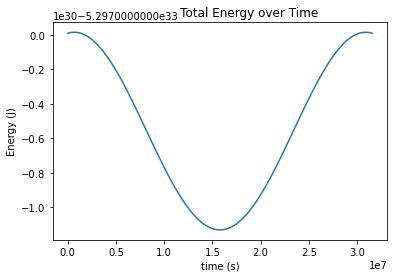

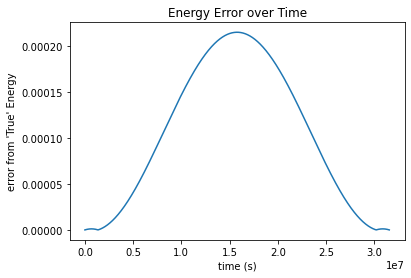

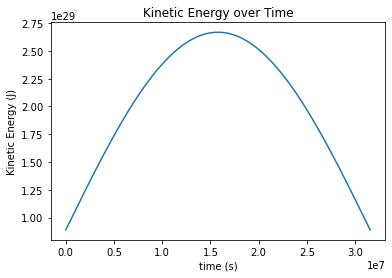

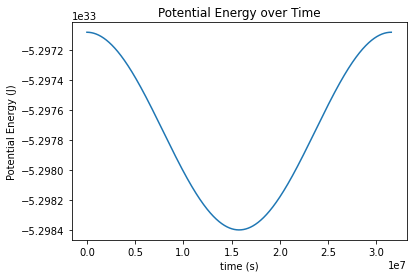

In [ ]:
# we make four plots
# 1. Total mechanical energy of the system over time
# 2. Energy error over time. error is a decimal error where the initial energy is treated as the true energy of the system
# 3. Kinetic Energy of the system over time
# 4. Potential Energy of the system over time
# the errors are decimal errors that can be converted to percents by multiplying by 100

plt.plot(times, energies)
plt.xlabel("time (s)")
plt.ylabel("Energy (J)")
plt.title("          Total Energy over Time")
plt.show()

energy_frac_err = abs((energies - np.array([energies[0]] * len(energies)))/energies[0])

plt.plot(times, energy_frac_err)
plt.xlabel("time (s)")
plt.ylabel("error from 'True' Energy")
plt.title("Energy Error over Time")
plt.show()

plt.plot(times, kinetic)
plt.xlabel("time (s)")
plt.ylabel("Kinetic Energy (J)")
plt.title("Kinetic Energy over Time")
plt.show()

plt.plot(times, potential)
plt.xlabel("time (s)")
plt.ylabel("Potential Energy (J)")
plt.title("Potential Energy over Time")
plt.show()

Here we attempt to determine initial parameters for a fictional binary star system. Notably this math does not create the simulation we wanted.

In [ ]:
# here we do some math to try and create a meaningful simulation that doesn't just eject planets and such

# gravitaitonal constant

G = 6.67430*10**(-11)

# we define mass and radii for two stars to make a binary

m1 = 1.16 * 1.988*10**30
r1 = 45.1 * 696000000

m2 = 1.018 * 1.988*10**30
r2 = 0.0084 * 696000000

# we take a desired period and use Kepler's Law to find the length of the semimajor axis

T = 20 * 24 * 3600

a = (G * (m1 + m2) / (4 * np.pi **2) * T ** 2)** (1/3)

# we define the desired eccentricity of the orbit and place the planets at their maximum distance from the bary center

eccentricity = 0.2
f = a*eccentricity
b = np.sqrt(a**2 - f**2)
p = p = b**2/a

r_max = p / (1 - eccentricity)

bary_center = m2* r_max / (m1 + m2)

x1 = -bary_center
x2 = r_max - bary_center
bary_center = 0

# we then use conslusions from Kepler's law to find appropriate velocities at the planet's maximum distance

v_y1 = np.sqrt(G * m2 * (1-eccentricity)/(a)/(1+eccentricity))
v_y2 = -np.sqrt(G * m1 * (1-eccentricity)/(a)/(1+eccentricity))

# we then define an earth like planet (its just the earth)

m3 = 5.9722 * 10**24
r3 = 6378000

# we define a desirable period and find the appropriate semimajor axis

T2 = 365 * 24 * 3600

a2 = (G * (m1 + m2 + m3) / (4 * np.pi **2) * T2 ** 2)** (1/3)

d3 = -a2

# we define the velocity for a circular orbit

v_y3 = -np.sqrt(G*(m1 + m2) / a2)

# we also define an orbital inclination and find good initial positions for the planet

orbital_angle = 20 * np.pi / 180

# this cosine was meant to be a sine but we are going to roll with it since this setup is fictional anyway

x3 = d3*np.cos(orbital_angle)
z3 = d3*np.cos(orbital_angle)

Binary Star Simulation

In [ ]:
# here we run the binary star simulation
# note: this simulation differs from the one shown during 
# the presentation due to a change in the orbital inclination and distance of the planet

times1, positions1, velocities1, collisions1, energies1, kinetic1, potential1 = n_body_model(np.array([[x1, 0, 0, 0, v_y1, 0, m1, r1], [x2, 0, 0, 0, v_y2, 0, m2, r2], [x3, 0, z3, 0, v_y3, 0, m3, r3]]), 60, 0, (2 * 31556926))
print(times1)
print(velocities1)
print(positions1)
print(collisions1)
print("Done")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
[0.000000e+00 6.000000e+01 1.200000e+02 ... 6.311382e+07 6.311388e+07
 6.311394e+07]
[[[ 0.00000000e+00  5.67507177e+04  0.00000000e+00]
  [ 0.00000000e+00 -6.05796087e+04  0.00000000e+00]
  [ 0.00000000e+00 -3.86145502e+04  0.00000000e+00]]

 [[ 7.19924208e+00  5.675

Export Binary Star Data

In [ ]:
# we then resize and export data into csvs

positions1 = positions1.reshape((len(positions1), 3 * 3))

indices1 = np.arange(1, 2921)*360
positions1_trunc = positions1[indices1]

np.savetxt("planetPositionsBinarySystemTruncated.csv", positions1_trunc, delimiter = ",")
np.savetxt("planetPositionsBinarySystem.csv", positions1, delimiter = ",")

velocities1 = velocities1.reshape((len(velocities1), 3 * 3))
np.savetxt("planetVelocitiesBinarySystem.csv", velocities1, delimiter = ",")

np.savetxt("timesBinarySystem.csv", times1, delimiter = ",")



Energy for Binary Star System

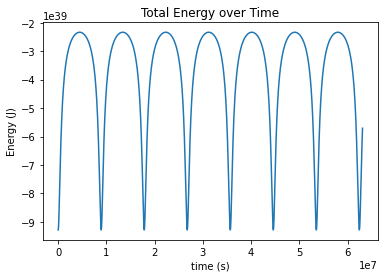

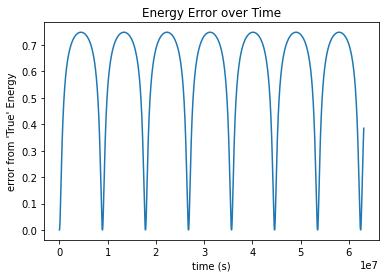

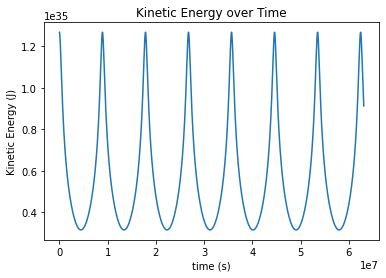

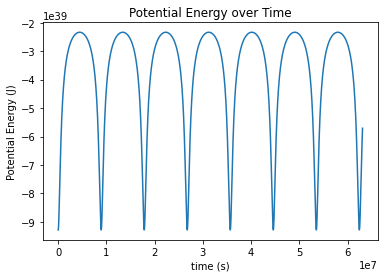

In [ ]:
# we make four plots
# 1. Total mechanical energy of the system over time
# 2. Energy error over time. error is a decimal error where the initial energy is treated as the true energy of the system
# 3. Kinetic Energy of the system over time
# 4. Potential Energy of the system over time

plt.plot(times1, energies1)
plt.xlabel("time (s)")
plt.ylabel("Energy (J)")
plt.title("Total Energy over Time")
plt.show()

energy_frac_err1 = abs((energies1 - np.array([energies1[0]] * len(energies1)))/energies1[0])

plt.plot(times1, energy_frac_err1)
plt.xlabel("time (s)")
plt.ylabel("error from 'True' Energy")
plt.title("Energy Error over Time")
plt.show()

plt.plot(times1, kinetic1)
plt.xlabel("time (s)")
plt.ylabel("Kinetic Energy (J)")
plt.title("Kinetic Energy over Time")
plt.show()

plt.plot(times1, potential1)
plt.xlabel("time (s)")
plt.ylabel("Potential Energy (J)")
plt.title("Potential Energy over Time")
plt.show()


Determining Initial Conditions for the Solar System

In [6]:
# here we define the orbital parameters for the planets of the solar system
# we assume the orbital inclinations are zero degrees
# we operate off of the same assumptions from the earth sun simulation

d_mars = 206.617 * 10 ** 9
v_mars = 26.50 * 1000
r_mars = 3376.2 * 1000
m_mars = 0.64171 * 10 ** 24
theta_mars = 37 * np.pi / 180

x_mars = d_mars * np.cos(theta_mars)
y_mars = d_mars * np.sin(theta_mars)

v_x_mars = v_mars * np.cos(theta_mars + np.pi / 2)
v_y_mars = v_mars * np.sin(theta_mars + np.pi / 2)

mars = [x_mars, y_mars, 0, v_x_mars, v_y_mars, 0, m_mars, r_mars]

x_earth = 152.099 * 10 ** 9
v_y_earth = 29.29 * 1000
r_earth = 6378000
m_earth = 5.9724 * 10 ** 24

earth = [x_earth, 0, 0, 0, v_y_earth, 0, m_earth, r_earth]

d_mercury = 46.002 * 10 ** 9
v_mercury = 58.98 * 1000
r_mercury = 2440.5 * 1000
m_mercury = 0.33011 * 10 ** 24
theta_mercury = -57 * np.pi / 180

x_mercury = d_mercury * np.cos(theta_mercury)
y_mercury = d_mercury * np.sin(theta_mercury)

v_x_mercury = v_mercury * np.cos(theta_mercury + np.pi / 2)
v_y_mercury = v_mercury * np.sin(theta_mercury + np.pi / 2)

mercury = [x_mercury, y_mercury, 0, v_x_mercury, v_y_mercury, 0, m_mercury, r_mercury]

d_venus = 108.939 * 10 ** 9
v_venus = 34.79 * 1000
r_venus = 6051.8 * 1000
m_venus = 4.8675 * 10 ** 24
theta_venus = 125 * np.pi / 180

x_venus = d_venus * np.cos(theta_venus)
y_venus = d_venus * np.sin(theta_venus)

v_x_venus = v_venus * np.cos(theta_venus + np.pi / 2)
v_y_venus = v_venus * np.sin(theta_venus + np.pi / 2)

venus = [x_venus, y_venus, 0, v_x_venus, v_y_venus, 0, m_venus, r_venus]

d_jupiter = 740.522 * 10 ** 9
v_jupiter = 13.72 * 1000
r_jupiter = 71492 * 1000
m_jupiter = 1898.19 * 10 ** 24
theta_jupiter = 89 * np.pi / 180

x_jupiter = d_jupiter * np.cos(theta_jupiter)
y_jupiter = d_jupiter * np.sin(theta_jupiter)

v_x_jupiter = v_jupiter * np.cos(theta_jupiter + np.pi / 2)
v_y_jupiter = v_jupiter * np.sin(theta_jupiter + np.pi / 2)

jupiter = [x_jupiter, y_jupiter, 0, v_x_jupiter, v_y_jupiter, 0, m_jupiter, r_jupiter]

d_saturn = 1514.504 * 10 ** 9
v_saturn = 9.09 * 1000 
r_saturn = 60268 * 1000
m_saturn = 568.34 * 10 ** 24
theta_saturn = 210 * np.pi / 180

x_saturn = d_saturn * np.cos(theta_saturn)
y_saturn = d_saturn * np.sin(theta_saturn)

v_x_saturn = v_saturn * np.cos(theta_saturn + np.pi / 2)
v_y_saturn = v_saturn * np.sin(theta_saturn + np.pi / 2)

saturn = [x_saturn, y_saturn, 0, v_x_saturn, v_y_saturn, 0, m_saturn, r_saturn]

d_uranus = 2741.302 * 10 ** 9
v_uranus = 7.11 * 1000
r_uranus = 25559 * 1000
m_uranus = 86.813 * 10 ** 24
theta_uranus = 285 * np.pi / 180

x_uranus = d_uranus * np.cos(theta_uranus)
y_uranus = d_uranus * np.sin(theta_uranus)

v_x_uranus = v_uranus * np.cos(theta_uranus + np.pi / 2)
v_y_uranus = v_uranus * np.sin(theta_uranus + np.pi / 2)

uranus = [x_uranus, y_uranus, 0, v_x_uranus, v_y_uranus, 0, m_uranus, r_uranus]

d_neptune = 4545.671 * 10 ** 9
v_neptune = 5.37 * 1000
r_neptune = 24764 * 1000
m_neptune = 102.413 * 10 ** 24
theta_neptune = 135 * np.pi / 180

x_neptune = d_neptune * np.cos(theta_neptune)
y_neptune = d_neptune * np.sin(theta_neptune)

v_x_neptune = v_neptune * np.cos(theta_neptune + np.pi / 2)
v_y_neptune = v_neptune * np.sin(theta_neptune + np.pi / 2)

neptune = [x_neptune, y_neptune, 0, v_x_neptune, v_y_neptune, 0, m_neptune, r_neptune]

m_sun = 1.988*10**30
r_sun = 696000000

sun = [0, 0, 0, 0, 0, 0, m_sun, r_sun]

initial_conditions_2 = np.array([sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune])


Solar System Simulation

In [30]:
# here we run the solar system simulation

times2, positions2, velocities2, collisions2, energies2, kinetic2, potential2 = n_body_model(initial_conditions_2, 600000, 0, 5e9)
print(times2)
print(velocities2)
print(positions2)
print(collisions2)
print("Done")

[1.30638486e-311 6.00000000e+005 1.20000000e+006 ... 4.99980000e+009
 5.00040000e+009 5.00100000e+009]
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 4.94647901e+04  3.21228103e+04  0.00000000e+00]
  [-2.84982996e+04 -1.99547242e+04  0.00000000e+00]
  ...
  [ 4.54500000e+03 -7.87217092e+03  0.00000000e+00]
  [ 6.86773262e+03  1.84020341e+03  0.00000000e+00]
  [-3.79716341e+03 -3.79716341e+03  0.00000000e+00]]

 [[-2.46967455e-03  1.43573345e-01  0.00000000e+00]
  [ 2.33449941e+04  5.11140060e+04  0.00000000e+00]
  [-2.41600915e+04 -2.50298347e+04  0.00000000e+00]
  ...
  [ 4.57503986e+03 -7.85474845e+03  0.00000000e+00]
  [ 6.86497921e+03  1.85044266e+03  0.00000000e+00]
  [-3.79443389e+03 -3.79989073e+03  0.00000000e+00]]

 [[-8.68741774e-03  2.89479668e-01  0.00000000e+00]
  [-3.50275774e+03  4.96246342e+04  0.00000000e+00]
  [-1.89310861e+04 -2.91789918e+04  0.00000000e+00]
  ...
  [ 4.60501685e+03 -7.83721780e+03  0.00000000e+00]
  [ 6.86220986e+03  1.86067760e+03  0.00000

Export Solar System Simulation Data

In [31]:
# truncate and export data

positions2 = positions2.reshape((len(positions2), 9 * 3))

indices2 = np.arange(1, 36520)*72
#positions2_trunc = positions2[1000]

#np.savetxt("planetPositionsSolarSystemTruncated.csv", positions2_trunc, delimiter = ",")
np.savetxt("planetPositionsSolarSystem.csv", positions2, delimiter = ",")

velocities2 = velocities2.reshape((len(velocities2), 9 * 3))
np.savetxt("planetVelocitiesSolarSystem.csv", velocities2, delimiter = ",")

np.savetxt("timesSolarSystem.csv", times2, delimiter = ",")

Energy of the Solar System

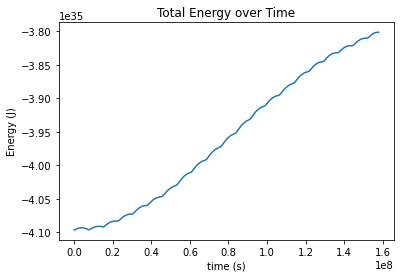

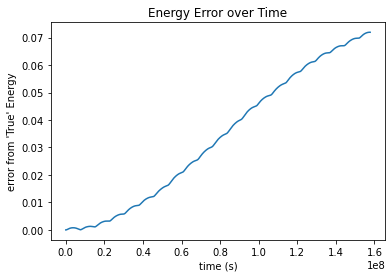

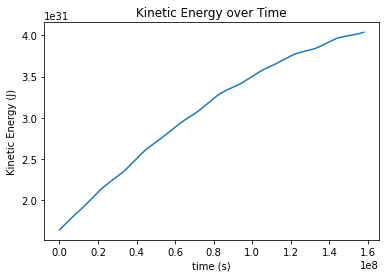

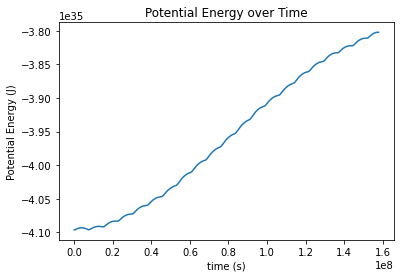

In [ ]:
# we make four plots
# 1. Total mechanical energy of the system over time
# 2. Energy error over time. error is a decimal error where the initial energy is treated as the true energy of the system
# 3. Kinetic Energy of the system over time
# 4. Potential Energy of the system over time

plt.plot(times2, energies2)
plt.xlabel("time (s)")
plt.ylabel("Energy (J)")
plt.title("Total Energy over Time")
plt.show()

energy_frac_err2 = abs((energies2 - np.array([energies2[0]] * len(energies2)))/energies2[0])

plt.plot(times2, energy_frac_err2)
plt.xlabel("time (s)")
plt.ylabel("error from 'True' Energy")
plt.title("Energy Error over Time")
plt.show()

plt.plot(times2, kinetic2)
plt.xlabel("time (s)")
plt.ylabel("Kinetic Energy (J)")
plt.title("Kinetic Energy over Time")
plt.show()

plt.plot(times2, potential2)
plt.xlabel("time (s)")
plt.ylabel("Potential Energy (J)")
plt.title("Potential Energy over Time")
plt.show()

Bonus: Moon Parameters

In [ ]:
# now we consdier the sun, earth, moon system operating off of the same assumptions/simplifications as before

m_sun = 1.988*10**30
r_sun = 696000000

sun = [0, 0, 0, 0, 0, 0, m_sun, r_sun]

x_earth = 152.099 * 10 ** 9
v_y_earth = 29.29 * 1000
r_earth = 6378000
m_earth = 5.9724 * 10 ** 24

earth = [x_earth, 0, 0, 0, v_y_earth, 0, m_earth, r_earth]

y_moon = 0.4055 * 10 ** 9
v_x_moon = -0.970 * 1000
r_moon = 1738 * 1000
m_moon = 0.07346 * 10 ** 24

moon = [x_earth, y_moon, 0, v_x_moon, v_y_earth, 0, m_moon, r_moon]

initial_conditions_3 = np.array([sun, earth, moon])

Bonus: Sun-Earth-Moon System

In [ ]:
# we run the earth-moon-sun simulation

times3, positions3, velocities3, collisions3, energies3, kinetic3, potential3 = n_body_model(initial_conditions_3, 60, 0, 24 * 3600 * 50)
print(times3)
print(velocities3)
print(positions3)
print(collisions3)
print("Done")

10000
20000
30000
40000
50000
60000
70000
[1.18584158e-311 6.00000000e+001 1.20000000e+002 ... 4.31994000e+006
 4.32000000e+006 4.32006000e+006]
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  2.92900000e+04  0.00000000e+00]
  [-9.70000000e+02  2.92900000e+04  0.00000000e+00]]

 [[ 1.04655556e-06  3.99473334e-11  0.00000000e+00]
  [-3.44128625e-01  2.92900018e+04  0.00000000e+00]
  [-9.70344115e+02  2.92898536e+04  0.00000000e+00]]

 [[ 2.09311112e-06  9.19869372e-11  0.00000000e+00]
  [-6.88257506e-01  2.92900036e+04  0.00000000e+00]
  [-9.70688208e+02  2.92897073e+04  0.00000000e+00]]

 ...

 [[ 6.71608831e-02  2.98051598e-02  0.00000000e+00]
  [-2.20916175e+04  1.94779204e+04  0.00000000e+00]
  [-2.24219337e+04  2.04281270e+04  0.00000000e+00]]

 [[ 6.71615934e-02  2.98059449e-02  0.00000000e+00]
  [-2.20918493e+04  1.94776629e+04  0.00000000e+00]
  [-2.24223102e+04  2.04278159e+04  0.00000000e+00]]

 [[ 6.71623038e-02  2.98067300e-02  0.00000000e+00]
  [-2.2

Export Earth-Sun-Moon Data

In [ ]:
# truncate and export data

positions3 = positions3.reshape((len(positions3), 3 * 3))

indices3 = np.arange(1, 2400)*30
positions3_trunc = positions3[indices3]

np.savetxt("planetPositionsMoonTruncated.csv", positions3_trunc, delimiter = ",")
np.savetxt("planetPositionsMoon.csv", positions3, delimiter = ",")

velocities3 = velocities3.reshape((len(velocities3), 3 * 3))
np.savetxt("planetVelocitiesMoon.csv", velocities3, delimiter = ",")

np.savetxt("timesMoon.csv", times3, delimiter = ",")

Energy of Earth-Sun-Moon System

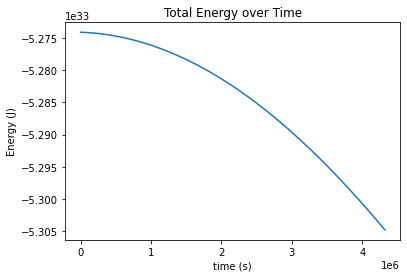

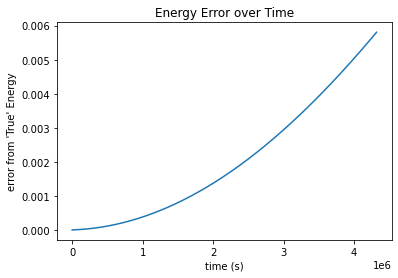

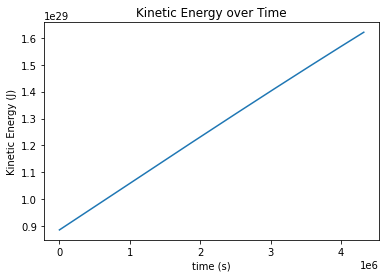

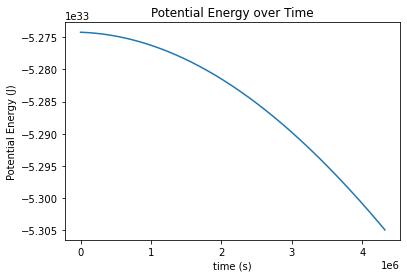

In [ ]:
# we make four plots
# 1. Total mechanical energy of the system over time
# 2. Energy error over time. error is a decimal error where the initial energy is treated as the true energy of the system
# 3. Kinetic Energy of the system over time
# 4. Potential Energy of the system over time

plt.plot(times3, energies3)
plt.xlabel("time (s)")
plt.ylabel("Energy (J)")
plt.title("Total Energy over Time")
plt.show()

energy_frac_err3 = abs((energies3 - np.array([energies3[0]] * len(energies3)))/energies3[0])

plt.plot(times3, energy_frac_err3)
plt.xlabel("time (s)")
plt.ylabel("error from 'True' Energy")
plt.title("Energy Error over Time")
plt.show()

plt.plot(times3, kinetic3)
plt.xlabel("time (s)")
plt.ylabel("Kinetic Energy (J)")
plt.title("Kinetic Energy over Time")
plt.show()

plt.plot(times3, potential3)
plt.xlabel("time (s)")
plt.ylabel("Potential Energy (J)")
plt.title("Potential Energy over Time")
plt.show()

Preparation for adding Pluto

In [ ]:
# now we will add pluto to the solar system simulation with an orbital inclination of 17.16 degrees
# we use the same assumptions as the other simulations modeled on the real world

theta_pluto = 17.16 * np.pi / 180
d_pluto = 7304.326 * 10 ** 9
v_y_pluto = 3.71 * 1000
m_pluto = 0.01303 * 10 ** 24
r_pluto = 1188 * 1000

x_pluto = d_pluto * np.cos(theta_pluto)
z_pluto = d_pluto * np.sin(theta_pluto)

pluto = [x_pluto, 0, z_pluto, 0, v_y_pluto, 0, m_pluto, r_pluto]

initial_conditions_4 = np.array([sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune, pluto])

Solar System Simulation with Pluto

In [ ]:
# run solar system simulation with pluto

times4, positions4, velocities4, collisions4, energies4, kinetic4, potential4 = n_body_model(initial_conditions_4, 3600, 0, 260 * 31556926)
print(times4)
print(velocities4)
print(positions4)
print(collisions4)
print("Done")

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
1390

Exporting Pluto Data

In [ ]:
# truncate and export data

positions4 = positions4.reshape((len(positions4), 10 * 3))

indices4 = np.arange(1, 94962)*24
positions4_trunc = positions4[indices4]

np.savetxt("planetPositionsSolarSystemPlutoTruncated.csv", positions4_trunc, delimiter = ",")
np.savetxt("planetPositionsSolarSystemPluto.csv", positions4, delimiter = ",")

velocities4 = velocities4.reshape((len(velocities4), 10 * 3))
np.savetxt("planetVelocitiesSolarSystemPluto.csv", velocities4, delimiter = ",")

np.savetxt("timesSolarSystemPluto.csv", times4, delimiter = ",")

Energy of Solar System with Pluto

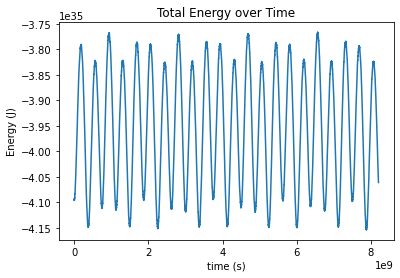

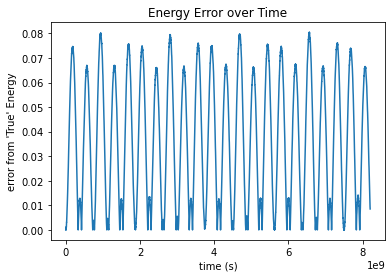

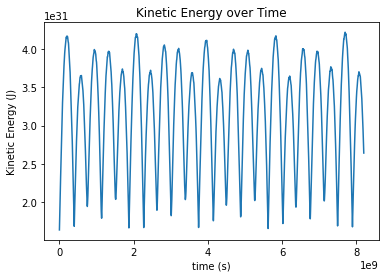

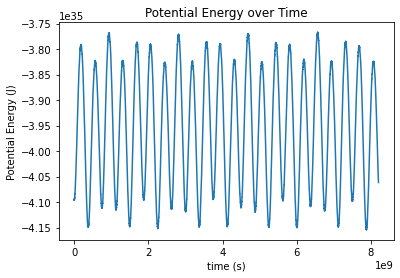

In [ ]:
# we make four plots
# 1. Total mechanical energy of the system over time
# 2. Energy error over time. error is a decimal error where the initial energy is treated as the true energy of the system
# 3. Kinetic Energy of the system over time
# 4. Potential Energy of the system over time

plt.plot(times4, energies4)
plt.xlabel("time (s)")
plt.ylabel("Energy (J)")
plt.title("Total Energy over Time")
plt.show()

energy_frac_err4 = abs((energies4 - np.array([energies4[0]] * len(energies4)))/energies4[0])

plt.plot(times4, energy_frac_err4)
plt.xlabel("time (s)")
plt.ylabel("error from 'True' Energy")
plt.title("Energy Error over Time")
plt.show()

plt.plot(times4, kinetic4)
plt.xlabel("time (s)")
plt.ylabel("Kinetic Energy (J)")
plt.title("Kinetic Energy over Time")
plt.show()

plt.plot(times4, potential4)
plt.xlabel("time (s)")
plt.ylabel("Potential Energy (J)")
plt.title("Potential Energy over Time")
plt.show()

Bibliography

Williams, D. R. (2019, October 21). Planetary Fact Sheet. NASA. https://nssdc.gsfc.nasa.gov/planetary/factsheet/.

Wikipedia. (2021, June 10). Leapfrog integration. https://en.wikipedia.org/wiki/Leapfrog_integration.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ed94618c-7db7-48f1-99aa-8d2a12e24eb8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>